# Multimodal search with CLIP

In this notebook we show-case SuperDuperDB's functionality for searching with multiple types of data over
the same `VectorIndex`. This comes out very naturally, due to the fact that SuperDuperDB allows
users and developers to add arbitrary models to SuperDuperDB, and (assuming they output vectors) use
these models at search/ inference time, to vectorize diverse queries.

To this end, we'll be using the [CLIP multimodal architecture](https://openai.com/research/clip).

In [ ]:
!pip install https://github.com/openai/CLIP

So let's start. 

SuperDuperDB supports MongoDB as a databackend. Correspondingly, we'll import the python MongoDB client `pymongo`
and "wrap" our database to convert it to a SuperDuper `Datalayer`:

In [1]:
import clip
import pymongo
from superduperdb.misc.superduper import superduper
from superduperdb.ext.torch.model import TorchModel
from superduperdb.ext.pillow.image import pil_image as i
from superduperdb.db.mongodb.query import Collection
from superduperdb.container.document import Document as D
from IPython.display import display

pymongo.MongoClient().drop_database('documents')
pymongo.MongoClient().drop_database('_filesystem:documents')

db = pymongo.MongoClient().documents
db = superduper(db)

collection = Collection(name='tiny-imagenet')

INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db.db.client.drop_database('documents')
db.db.client.drop_database('_filesystem:documents')

In order to make this notebook easy to execute an play with, we'll use a sub-sample of the [Tiny-Imagenet
dataset](https://paperswithcode.com/dataset/tiny-imagenet). 

Everything we are doing here generalizes to much larger datasets, with higher resolution images, without
further ado. For such use-cases, however, it's advisable to use a machine with a GPU, otherwise they'll 
be some significant thumb twiddling to do.

To get the images into the database, we use the `Encoder`-`Document` framework. This allows
us to save Python class instances as blobs in the `Datalayer`, but retrieve them as Python objects.
This makes it far easier to integrate Python AI-models with the datalayer.

To this end, SuperDuperDB contains pre-configured support for `PIL.Image` instances. It's also 
possible to create your own encoders.

In [3]:
from superduperdb.container.document import Document as D
from superduperdb.ext.pillow.image import pil_image as i
from datasets import load_dataset
import random

dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
dataset = [D({'image': i(r['image'])}) for r in dataset]
dataset = random.sample(dataset, 1000)

  0%|          | 0/2 [00:00<?, ?it/s]

The wrapped python dictionaries may be inserted directly to the `Datalayer`:

In [4]:
db.execute(collection.insert_many(dataset, encoders=(i,)))

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x19c017970>,
 TaskWorkflow(database=<superduperdb.db.base.datalayer.Datalayer object at 0x180d09150>, G=<networkx.classes.digraph.DiGraph object at 0x19d175550>))

We can verify that the images are correctly stored:

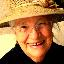

In [5]:
x = db.execute(collection.find_one())['image'].x
x

We now can wrap the CLIP model, to ready it for multimodel search. It involves 2 components:

- text-encoding
- visual-encoding

Once we have installed both parts, we will be able to search with both images and text for 
matching items:

In [6]:
from superduperdb.ext.torch.tensor import tensor
import torch

t = tensor(torch.float, shape=(512,))

model, preprocess = clip.load("ViT-B/32", device='cpu')

text_model = TorchModel(
    identifier='clip_text',
    object=model,
    preprocess=lambda x: clip.tokenize(x)[0],
    forward_method='encode_text',
    encoder=t
)

Let's verify this works:

In [7]:
text_model.predict('this is a test', one=True)

tensor([ 1.5430e-01,  8.3419e-02, -8.6218e-02, -2.4812e-01, -9.0193e-02,
        -1.7874e-01,  7.9648e-02, -1.4377e+00,  9.5243e-02,  2.9510e-01,
         4.2066e-03,  2.5638e-01, -2.1601e-02,  1.5735e-02,  1.9318e-01,
        -1.6119e-01,  3.6999e-01,  2.2594e-02, -5.7204e-02, -1.9817e-01,
        -7.5301e-03, -3.2254e-01,  2.7348e-01, -3.5396e-01, -1.9037e-01,
         1.0515e-01, -2.4183e-02,  1.0074e-01, -8.8070e-02,  2.6366e-02,
        -2.7968e-01, -2.9460e-01,  2.1931e-02,  1.1822e-01,  8.7239e-02,
         1.1945e-01, -6.0540e-04, -1.0101e-01, -1.0430e-01, -2.0626e-01,
        -1.3790e-01, -3.9173e-02,  7.5546e-03,  1.3866e-01, -1.1169e-01,
         1.1691e-01, -1.8521e-01,  2.9997e-02,  1.0280e-01,  1.1497e-01,
        -1.0389e-01,  5.0075e-02,  3.1277e-01, -1.7357e-01,  4.6908e-02,
        -9.6962e-02,  7.7737e-02,  4.9121e-03, -2.9044e-01, -3.6215e-02,
         3.3161e-01,  4.0403e-02, -3.6717e-02,  3.3114e-02,  1.3841e-01,
         1.1665e-01, -1.8533e-01,  1.4537e-01,  1.7

Similar procedure with the visual part, which takes `PIL.Image` instances as inputs.

In [8]:
visual_model = TorchModel(
    identifier='clip_image',
    preprocess=preprocess,
    object=model.visual,
    encoder=t,
)

In [9]:
visual_model.predict(x, one=True)

tensor([ 5.2043e-01,  1.0270e-01, -1.6637e-01, -8.1837e-02,  3.2631e-01,
        -2.6725e-01,  2.0737e-01,  1.0318e-01,  3.0355e-01,  1.2646e-01,
         5.8931e-01,  1.4478e-01,  6.9098e-01, -9.3980e-03,  8.9068e-03,
         2.3743e-01,  1.5705e+00, -8.6127e-02,  4.4043e-01, -4.5310e-01,
         1.0495e-01, -2.2952e-02, -3.7425e-01, -4.2250e-01,  8.5663e-02,
        -1.0094e-01,  2.4356e-01, -6.8332e-02, -1.2649e-01, -3.8987e-02,
         5.7936e-01,  1.3255e-01,  2.0159e-01, -4.2401e-01, -6.1544e-01,
        -1.0422e-01,  4.1886e-01, -9.7044e-02, -7.5444e-01,  7.2815e-01,
         2.4978e-01, -2.8653e-01,  7.2046e-02, -5.9999e-01, -1.1457e-01,
         2.7741e-01, -2.2757e-01,  3.0143e-01,  1.1462e+00, -1.1495e-01,
         6.0567e-01,  9.0946e-02, -2.0426e-01,  6.4193e-01, -4.1416e-01,
        -1.5787e-02,  3.4258e-01, -9.8345e-02, -2.9025e-02,  2.5182e-01,
         6.9864e-01,  3.0304e-01,  1.9787e-01,  1.3170e-01, -4.8386e-01,
        -2.9302e-02, -2.6883e-01,  2.8705e-01,  4.6

Now let's create the index for searching by vector. We register both models with the index simultaneously,
but specifying that it's the `visual_model` which will be responsible for creating the vectors in the database
(`indexing_watcher`). The `compatible_watcher` specifies how one can use an alternative model to search 
the vectors. By using models which expect different types of index, we can implement multimodal search
without further ado.

In [10]:
from superduperdb.container.vector_index import VectorIndex
from superduperdb.container.watcher import Watcher

db.add(
    VectorIndex(
        'my-index',
        indexing_watcher=Watcher(
            model=visual_model,
            key='image',
            select=collection.find(),
        ),
        compatible_watcher=Watcher(
            model=text_model,
            key='text',
            active=False,
        )
    )
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:37<00:00,  3.61it/s]
INFO:root:loading hashes: 'my-index'
/Users/dodo/SuperDuperDB/superduperdb/superduperdb/ext/torch/tensor.py:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(array)


[]

We can now demonstrate searching by text for images:

INFO:root:loading hashes: 'my-index'


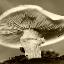

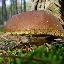

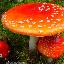

In [11]:
out = db.execute(
    collection.like(D({'text': 'mushroom'}), vector_index='my-index', n=3).find({})
)
for r in out:
    display(r['image'].x)